# Ray Tracing Canonical Examples

In [207]:
# data handling
import numpy as np
import xarray as xr

# plotting
import matplotlib.pyplot as plt
from IPython.display import HTML
import cmocean

# ray tracing
import mantaray

# helper functions
import utils

## Introduction

This notebook covers how to run Mantaray with the custom depth and current fields that were constructed in `idealized_fields.ipynb`. It is recommended that users run through this notebook first.

## Initial Wave and Model Parameters

The initial wave parameters that we need to define for Mantaray are $k_{x0}$/$k_{y_0}$, the initial x/y wavenumber. We will calculate these from the following parameters:
- $T_0$: The initial way period,
- $\theta_0$: The initial wave direction (convention: what direction the waves are *going to*),
- $n_{rays}$: The number of rays.

All waves will have the same x/y wavenumbers. We will use these initial parameters for the 4 canonical examples.

In [208]:
T0 = 10  # Period [s]
theta0 = 0  # Direction [rad]

In [209]:
# Convert period to wavenumber magnitude
k_0 = utils.period2wavenumber(T0)

# Calculate wavenumber components
k_x0 = k_0 * np.cos(theta0)
k_y0 = k_0 * np.sin(theta0)

In [210]:
# Number of rays
n_rays = 100

# Initialize wavenumber for all rays
K_x0 = k_x0 * np.ones(n_rays)
K_y0 = k_y0 * np.ones(n_rays)

Additionally, we need to define the initial positions for all of our rays. To do this, we will extract the grid from one of our canonical examples. All examples have the same grid, and the initial positions for all rays will be the same for each canonical example.

In [211]:
ds_jet = xr.open_dataset("./forcing/zonal_jet.nc")

In [212]:
# Read x and y from file to get domain size
x = ds_jet.x.values
y = ds_jet.y.values

In [213]:
x0 = 0 * np.ones(n_rays)
y0 = np.linspace(0, y.max(), n_rays)

Additionally, using the grid, we can compute the optimal timestep and duration for each model.

In [214]:
timestep = utils.compute_cfl(x, y, k_0)
duration = utils.compute_duration(x, k_0)

## Ray Tracing with Mantaray

The core ray tracing function expects:
- Initial x and y position(s),
- Initial $k_{x0}$ and $k_{y0}$(s),
- Model duration,
- Model timestep,
- Bathymetry/Current `xarray` `datasets` *paths* as *strings*

### Zonal Jet

If `idealized_fields.ipynb` was run properly, the paths below should be where the data for the zonal jet and constant bathymetry should be located.

In [215]:
jet_path = "./forcing/zonal_jet.nc"
const_bathy_path = "./forcing/4000m_bathymetry.nc"

In [216]:
bundle_jet = mantaray.ray_tracing(
    x0, y0, K_x0, K_y0, duration, timestep, const_bathy_path, jet_path
)

In [217]:
bundle_jet

<xarray.Dataset> Size: 802kB
Dimensions:    (time_step: 200, ray: 100)
Coordinates:
    time       (time_step, ray) float64 160kB 0.0 0.0 0.0 ... 2.549e+04 nan
    x          (time_step, ray) float64 160kB 0.0 0.0 0.0 ... 1.989e+05 nan
    y          (time_step, ray) float64 160kB 0.0 1e+03 2e+03 ... 9.81e+04 nan
  * time_step  (time_step) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * ray        (ray) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    kx         (time_step, ray) float64 160kB 0.04024 0.04024 ... 0.04024 nan
    ky         (time_step, ray) float64 160kB 0.0 0.0 0.0 ... 3.893e-05 nan
Attributes:
    date_created:  2025-04-29 15:06:01.681124

In [220]:
# bundle_jet.to_netcdf("./output/bundle4zonal_jet.nc", format="NETCDF3_CLASSIC")

Our ray tracing code executed properly. We can make a quick plot to see if this is working properly before creating animations.

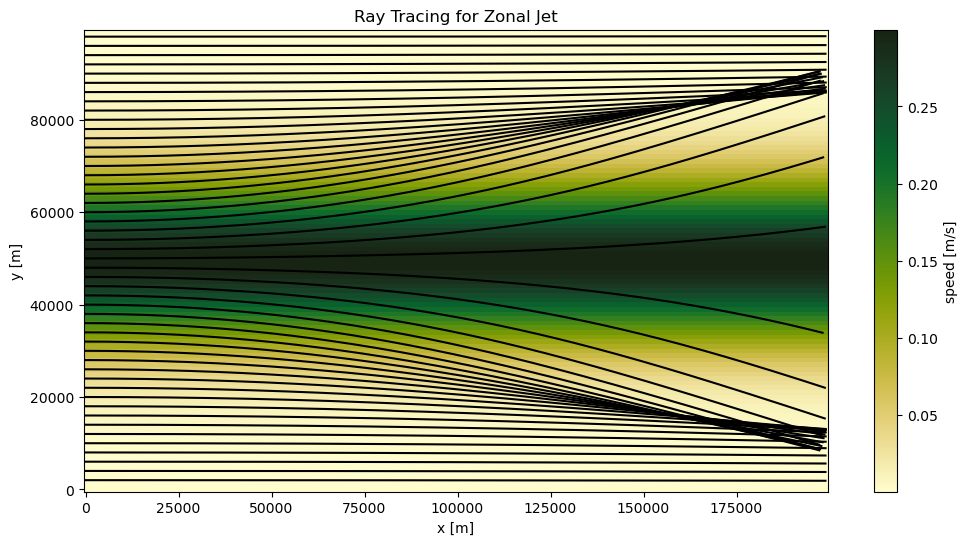

In [221]:
X = ds_jet.x
Y = ds_jet.y
U = (ds_jet.u**2 + ds_jet.v**2) ** 0.5

plt.figure(figsize=(12, 6))

cf = plt.pcolormesh(X, Y, U, cmap=cmocean.cm.speed)

for i in range(bundle_jet.ray.size)[::2]:
    ray = bundle_jet.isel(ray=i)
    plt.plot(ray.x.values, ray.y.values, color="black")

plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.colorbar(cf, label="speed [m/s]")
plt.title("Ray Tracing for Zonal Jet")

plt.show()

### Mesoscale Eddy

In [222]:
eddy_path = "./forcing/mesoscale_eddy.nc"

In [223]:
bundle_eddy = mantaray.ray_tracing(
    x0, y0, K_x0, K_y0, duration, timestep, const_bathy_path, eddy_path
)

In [225]:
# bundle_eddy.to_netcdf("./output/bundle4eddy.nc", format="NETCDF3_CLASSIC")

In [226]:
ds_eddy = xr.open_dataset(eddy_path)

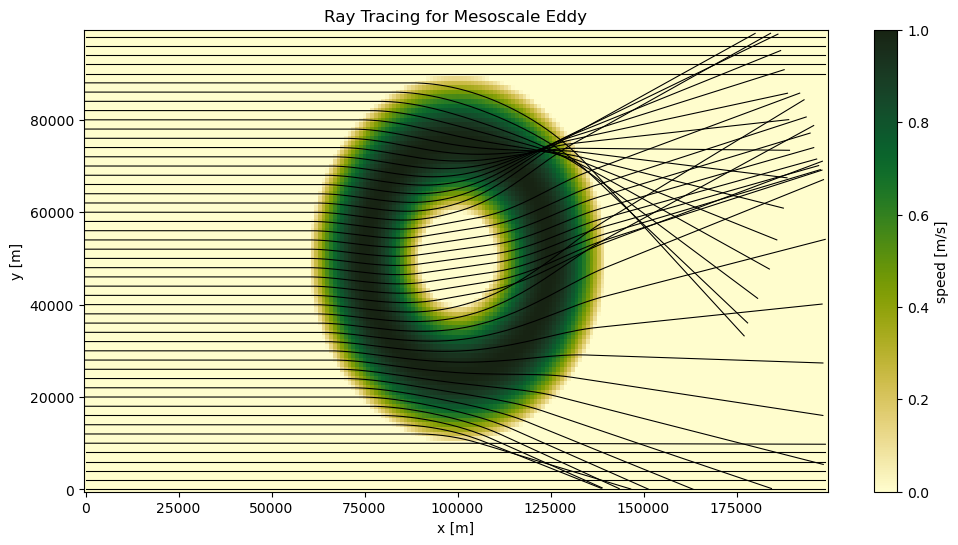

In [227]:
X = ds_eddy.x
Y = ds_eddy.y
U = (ds_eddy.u**2 + ds_eddy.v**2) ** 0.5

plt.figure(figsize=(12, 6))

cf = plt.pcolormesh(X, Y, U, cmap=cmocean.cm.speed)

for i in range(bundle_eddy.ray.size)[::2]:
    ray = bundle_eddy.isel(ray=i)
    plt.plot(ray.x, ray.y, "k", lw=0.78)

plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.colorbar(cf, label="speed [m/s]")
plt.title("Ray Tracing for Mesoscale Eddy")

plt.show()

### Gaussian Island

In [228]:
static_cur_path = "./forcing/homogeneous.nc"
island_path = "./forcing/gaussian_island.nc"

In [229]:
bundle_island = mantaray.ray_tracing(
    x0, y0, K_x0, K_y0, duration, timestep, island_path, static_cur_path
)

In [231]:
# bundle_island.to_netcdf("./output/bundle4island.nc", format="NETCDF3_CLASSIC")

In [232]:
ds_island = xr.open_dataset(island_path)

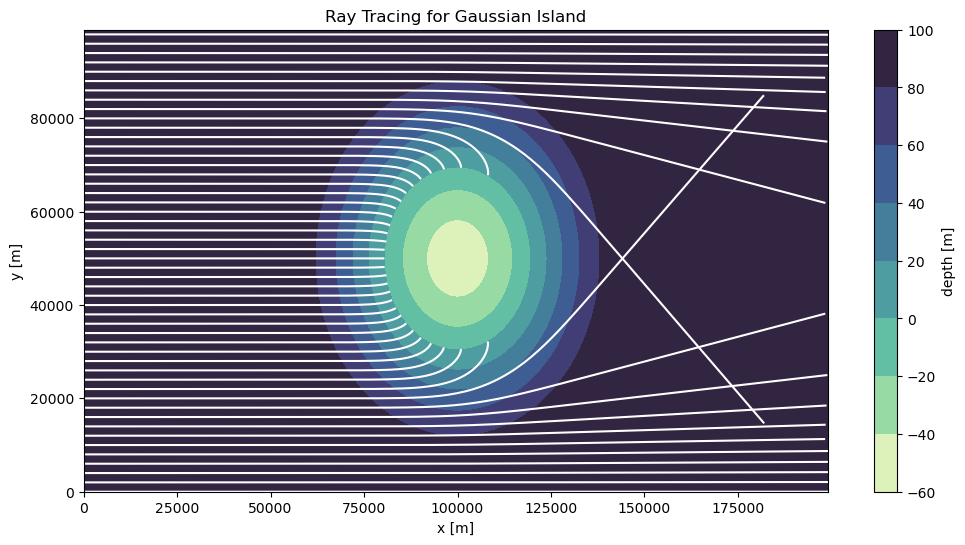

In [233]:
X = ds_eddy.x
Y = ds_eddy.y
H = ds_island.depth

plt.figure(figsize=(12, 6))

cf = plt.contourf(X, Y, H, cmap=cmocean.cm.deep)

for i in range(bundle_island.ray.size)[::2]:
    ray = bundle_island.isel(ray=i)
    plt.plot(ray.x, ray.y, color="white")

plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.colorbar(cf, label="depth [m]")
plt.title("Ray Tracing for Gaussian Island")

plt.show()

## Interactive Animations

Any ray tracing example can be animated. For any example, you need to extract:
- The x/y grid from the currents/bathymetry dataset
- The background field from the currents/bathymetry dataset

In [236]:
X = ds_island.x
Y = ds_island.y
depth = ds_island.depth

Below, we create the frames of the animation.

In [239]:
island_anim = utils.animate_rays(
    X, Y, depth, bundle_island, style="bathymetry", ray_sample=2, time_sample=5
)

Then, we can plot the animation so that it is interactive. WARNING: this cell may take some time to run.

In [240]:
HTML(island_anim.to_jshtml())

Optionally, the animation can be saved.

In [139]:
# anim.save('./output/waves.gif')

## Bonus Examples

### Sloped Beach

For this example, we will start the rays from a line on an angle.

In [241]:
theta0 = np.deg2rad(35)

# Calculate wavenumber components
k_x0 = k_0 * np.cos(theta0)
k_y0 = k_0 * np.sin(theta0)

In [242]:
n_rays = 50

# Initialize wavenumber for all rays
Kx0 = k_x0 * np.ones(n_rays)
Ky0 = k_y0 * np.ones(n_rays)

The CFL and duration funtions assume that the rays are moving from the left side of the domain to the right, so they are not a perfect estimate here, but they'll still work.

In [245]:
step_size = utils.compute_cfl(x, y, k_0)
duration = utils.compute_duration(x, k_0)

We have calculated the x/y wavenumber components for waves traveling at 35 degrees, but we now need to define their initial positions along an angled line.

In [246]:
# Parameters
x_start = 50_000  # Start x coordinate [m]
y_start = 0  # Start y coordinate [m]
line_length = 50_000  # Total length of the line [m]

# Calculate the step size in the x and y directions
dx = -line_length / n_rays * np.cos(np.pi / 2 - theta0)
dy = line_length / n_rays * np.sin(np.pi / 2 - np.pi / 4)

# Generate the coordinates along the line
x0 = x_start + np.linspace(0, dx * (n_rays - 1), n_rays)  # x coordinates
y0 = y_start + np.linspace(0, dy * (n_rays - 1), n_rays)  # y coordinates

In [247]:
beach_path = "./forcing/gentle_slope.nc"

In [248]:
bundle_beach = mantaray.ray_tracing(
    x0, y0, Kx0, Ky0, duration, 10, beach_path, static_cur_path
)

In [250]:
# bundle_beach.to_netcdf("./output/bundle4beach.nc", format="NETCDF3_CLASSIC")

In [251]:
ds_beach = xr.open_dataset(beach_path)

/var/folders/30/l7lkprrx2c32s7j5y82c67300000gq/T/ipykernel_90471/1316495833.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(ray.x, ray.y, "k", lw=0.78, color="white")


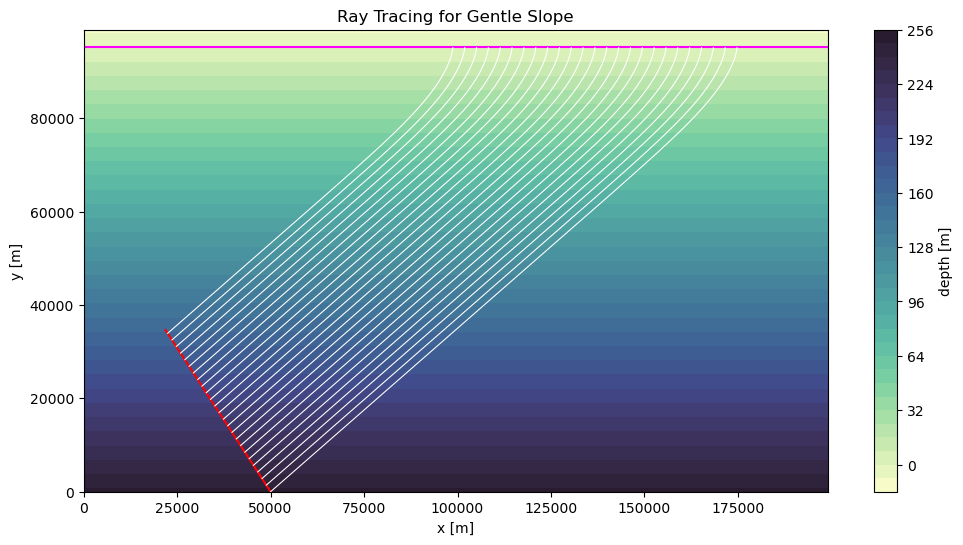

In [252]:
X = ds_beach.x
Y = ds_beach.y
H = ds_beach.depth

plt.figure(figsize=(12, 6))

cf = plt.contourf(X, Y, H, cmap=cmocean.cm.deep, levels=40)
line = plt.plot(x0, y0, label="Line at points (x0, y0)", color="red")

plt.contour(X, Y, H, 0, colors="magenta")


for i in range(bundle_beach.ray.size)[::2]:
    ray = bundle_beach.isel(ray=i)
    plt.plot(ray.x, ray.y, "k", lw=0.78, color="white")

plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.colorbar(cf, label="depth [m]")
plt.title("Ray Tracing for Gentle Slope")
plt.show()